In [1]:
import pandas as pd
import geopandas as gpd
from os import listdir
from os.path import join
import r5py

# Loading transit network

In [4]:
listGTFSpaths = [
    '../gtfsData/busesEMT_9may2025.zip', # buses EMT
    '../gtfsData/metro_30may2025.zip', # metro
    '../gtfsData/metroLigero_26feb2025.zip', # metro ligero
    '../gtfsData/cercanias_23july2025_fromRenfe.zip' # cercanias
] + [join('../gtfsData/busesInterurbanos_Urbanos_all_16july2025/', i) for i in listdir('../gtfsData/busesInterurbanos_Urbanos_all_16july2025/')]

madridOSMpath = '../osmData/madrid-latest.osm.pbf' 

transport_network = r5py.TransportNetwork(
    madridOSMpath,
    listGTFSpaths,
    allow_errors=True
)

/home/izzy/miniconda3/envs/tfm/lib/python3.12/site-packages/r5py/r5/transport_network.py:113: RuntimeWarning: R5 reported the following issues with GTFS file metro_30may2025.zip: 
EmptyTableError: fare_attributes line 0: Table is present in zip file, but it has no entries.
- EmptyTableError: fare_rules line 0: Table is present in zip file, but it has no entries.
  warnings.warn(
/home/izzy/miniconda3/envs/tfm/lib/python3.12/site-packages/r5py/r5/transport_network.py:113: RuntimeWarning: R5 reported the following issues with GTFS file metroLigero_26feb2025.zip: 
EmptyTableError: frequencies line 0: Table is present in zip file, but it has no entries.
- EmptyTableError: fare_attributes line 0: Table is present in zip file, but it has no entries.
- EmptyTableError: fare_rules line 0: Table is present in zip file, but it has no entries.
  warnings.warn(
/home/izzy/miniconda3/envs/tfm/lib/python3.12/site-packages/r5py/r5/transport_network.py:113: RuntimeWarning: R5 reported the following is

In [ ]:
gpd.GeoSeries(transport_network.extent).set_crs('EPSG:4326').explore()

# origins and destinations


## origins

In [5]:
madridGrid = gpd.read_file('../populationData/madridMunicipios_clippedESTAT2021.gpkg').set_crs('EPSG:3035').to_crs("EPSG:4326")[['GRD_ID', 'T', 'M', 'F', 'geometry']]
madridGrid.explore()

<Axes: >

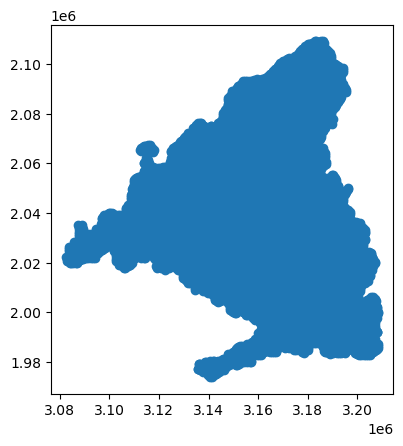

In [6]:
pointOrigins = madridGrid.copy().to_crs('EPSG:3035')
pointOrigins['geometry'] = pointOrigins['geometry'].centroid
pointOrigins.to_crs(madridGrid.crs)
pointOrigins = pointOrigins.rename({'GRD_ID' : 'id'}, axis=1)

pointOrigins.plot()

## destinations

we will have the following destinations:
- libaries
- schools at the infantil, primaria and secundaria level
- universities
- health centers
- other health centers like elderly homes and shelters
- places of worship

We will begin with libraries as this is a small and easy to understand set that will help us see if our approach works.

In [13]:
gdf_libraries.columns

Index(['PK', 'NOMBRE', 'BARRIO', 'COD-DISTRITO', 'DISTRITO', 'COORDENADA-X',
       'COORDENADA-Y', 'geometry'],
      dtype='object')

In [14]:
gdf_libraries = gpd.read_file('../POIs/bibliotecas/cleaned/bibliotecasTodo.geojson').rename({'PK' : 'id'}, axis=1)

pointDestinations = gdf_libraries.to_crs('EPSG:3035') # in this case this geoDataFrame is already in this CRS, but it is good practice to set them all to this to have things consistent


gdf_libraries.shape

(240, 8)

# Generating matrix

In [ ]:
import datetime

travel_time_matrix = r5py.TravelTimeMatrix(
    transport_network= transport_network,
    origins = pointOrigins,
    destinations = pointDestinations,
    transport_modes = [r5py.TransportMode.TRANSIT],
    departure=datetime.datetime(2025, 7, 28, 14, 0, 0)
)

travel_time_matrix = pd.DataFrame(travel_time_matrix)

In [ ]:
travel_time_matrix.dropna().sort_values(by='travel_time', ascending=False)

from_id                            to_id  \
339051  CRS3035RES1000mN1978000E3135000  CRS3035RES1000mN1975000E3141000   
67819   CRS3035RES1000mN1975000E3138000  CRS3035RES1000mN1975000E3141000   
84771   CRS3035RES1000mN1975000E3140000  CRS3035RES1000mN1975000E3141000   
347527  CRS3035RES1000mN1978000E3136000  CRS3035RES1000mN1975000E3141000   
59343   CRS3035RES1000mN1975000E3137000  CRS3035RES1000mN1975000E3141000   
...                                 ...                              ...   
67816   CRS3035RES1000mN1975000E3138000  CRS3035RES1000mN1975000E3138000   
330603  CRS3035RES1000mN1977000E3147000  CRS3035RES1000mN1977000E3147000   
254310  CRS3035RES1000mN1977000E3138000  CRS3035RES1000mN1977000E3138000   
406896  CRS3035RES1000mN1978000E3143000  CRS3035RES1000mN1978000E3143000   
372988  CRS3035RES1000mN1978000E3139000  CRS3035RES1000mN1978000E3139000   

        travel_time  
339051        162.0  
67819         162.0  
84771         161.0  
347527        158.0  
59343         152.0  
...             ...  
67816           0.0  
330603          0.0  
254310          0.0  
406896          0.0  
372988          0.0  

[2330 rows x 3 columns]